In [233]:
import pandas as pd
import plotnine as pn
import numpy as np

In [234]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

,density,edginess,references,citations_per_year,is_center,identifier,year,librarian,vectorizer,center,fields_of_study_0
0,41.100833,0.679679,109,1.333333,False,1ccf300b3f4965f831a41232ba4b7c0c3c90d929,2020,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
1,38.076275,0.721620,88,44.818182,False,1d4e43c1be145f6711ec00af900a8658d82623a0,2012,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
2,41.553209,0.708944,69,5.125000,False,16e772e28b3470cb0050328c6e5a500882ff15ae,2015,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
3,30.062907,0.686039,179,0.000000,False,0bc5bf8a556f158b1bdaada28ce9cbd28c5d55a4,2017,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
4,39.494263,0.681023,55,1.500000,False,35d7b77f2a6436124346d80aabc4bd66d5e0bd8b,2017,S2,SciBERT,hafenLowredshiftLymanLimit2017,Physics
...,...,...,...,...,...,...,...,...,...,...,...
117380,36.393984,0.617086,41,5.937500,False,292cda51a31a6b4a020d37e9aada6a33012e35a6,2007,S2,SciBERT,Torres2013,Medicine
117381,32.849134,0.758446,72,4.666667,False,7aed9a174830253295b571e9e32b88fc0c825b33,2014,S2,SciBERT,Torres2013,Medicine
117382,31.422958,0.704501,296,94.500000,False,5223c53ed3f4dc3aa7811ea090b458046b281cc6,2015,S2,SciBERT,Torres2013,Medicine
117383,35.579523,0.651514,24,5.937500,False,711311fc4d9d1b715040efa4cd0612e02b45febf,2007,S2,SciBERT,Torres2013,Medicine


In [235]:

def entropy_estimator(observations: np.ndarray, num_bins: int = 10, bins = range(10)) -> float:
    """Estimate the entropy of a vector of observations by binning the values. Since we typically only look at cpy in the range [0,10], we simply assign 1 bin for each value in this range."""

    if not observations.size:
        return np.nan

    # Calculate min and max values
    min_value = np.min(observations)
    max_value = np.max(observations)

    # Calculate bin width for each dimension
    bin_width = (max_value - min_value) / (num_bins+1)

    # Compute histogram
    if bins is None:
        kwargs = dict(
            bins=num_bins, 
            range=(min_value, max_value),
        )
    else:
        kwargs = dict(bins=bins)
    hist, _ = np.histogram(observations, **kwargs)

    # Compute probabilities for each bin
    bin_probabilities = hist / len(observations)

    # Calculate entropy for this dimension
    entropy_estimate = -np.sum(bin_probabilities * np.log(bin_probabilities + 1e-16) / bin_width)  # Add small value to avoid log(0)

    return entropy_estimate

## Transform data

In [236]:
# df = df_all[df_all["citations_per_year"] > 0]
df = df_all[df_all["density"] < 100] # hacky
df["log_cpy"] = np.log10(df["citations_per_year"])
df['log_cpy'] = df['log_cpy'].replace(-np.inf, np.nan)

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_17001/92397243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_17001/92397243.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [237]:
# General function for cutting and estimating cpy entropy for a subset of dataframe

def get_df_ent(df_in: pd.DataFrame, field: str, num_bins = 100) -> pd.DataFrame:

    # Filter
    df = df_in[df_in["fields_of_study_0"] == field]

    # cut
    df['density_bin'] = pd.cut(
        df['density'], 
        bins=np.linspace(
            df['density'].min(), 
            df['density'].max(), 
            num=num_bins+1,
        ),
    )

    # cpy_bins = df[["citations_per_year", "density_bin"]]    
    log_cpy_bins = df[["log_cpy", "density_bin"]]    

    ents = [
        entropy_estimator(
            observations=log_cpy_bins[log_cpy_bins["density_bin"] == bin]["log_cpy"].values, 
            num_bins=num_bins,
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]

    # just look at variance for now
    variances = [
            np.nanvar(
            log_cpy_bins[log_cpy_bins["density_bin"] == bin]["log_cpy"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]

    bins = [item.left for item in df.density_bin.value_counts(sort=False, normalize=True).keys()]
    df_ent = pd.DataFrame(
        data=zip(bins, df.density_bin.value_counts(sort=False, normalize=True), ents, variances),
        columns=["density_bin", "freq", "log_cpy entropy", "log_cpy variance"],
    )
    df_ent["field"] = field

    return df_ent


In [238]:
# debug counts
get_df_ent(df, "Physics")

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_17001/1209397614.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,density_bin,freq,log_cpy entropy,log_cpy variance,field
0,15.983,0.000137,-0.0,0.026422,Physics
1,16.346,0.000343,NaN,0.000335,Physics
2,16.709,0.000685,NaN,0.155380,Physics
3,17.072,0.000343,NaN,1.048072,Physics
4,17.435,0.000754,NaN,0.595170,Physics
...,...,...,...,...,...
95,50.457,0.000822,NaN,0.171584,Physics
96,50.820,0.000480,NaN,0.209556,Physics
97,51.183,0.000206,-0.0,0.043945,Physics
98,51.546,0.000343,NaN,0.122696,Physics


In [239]:
df_ent_all = pd.concat(
    [get_df_ent(df, field)
    for field in df_all["fields_of_study_0"].unique()],
)
df_ent_all

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_17001/1209397614.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_17001/1209397614.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_17001/1151388027.py:28: RuntimeWarning: divide by zero encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_17001/1151388027.py:28: RuntimeWarning: invalid value encountered

,density_bin,freq,log_cpy entropy,log_cpy variance,field
0,15.983,0.000137,-0.0,0.026422,Physics
1,16.346,0.000343,NaN,0.000335,Physics
2,16.709,0.000685,NaN,0.155380,Physics
3,17.072,0.000343,NaN,1.048072,Physics
4,17.435,0.000754,NaN,0.595170,Physics
...,...,...,...,...,...
95,74.857,0.000000,NaN,NaN,Medicine
96,75.494,0.000000,NaN,NaN,Medicine
97,76.130,0.000059,NaN,NaN,Medicine
98,76.767,0.000000,NaN,NaN,Medicine


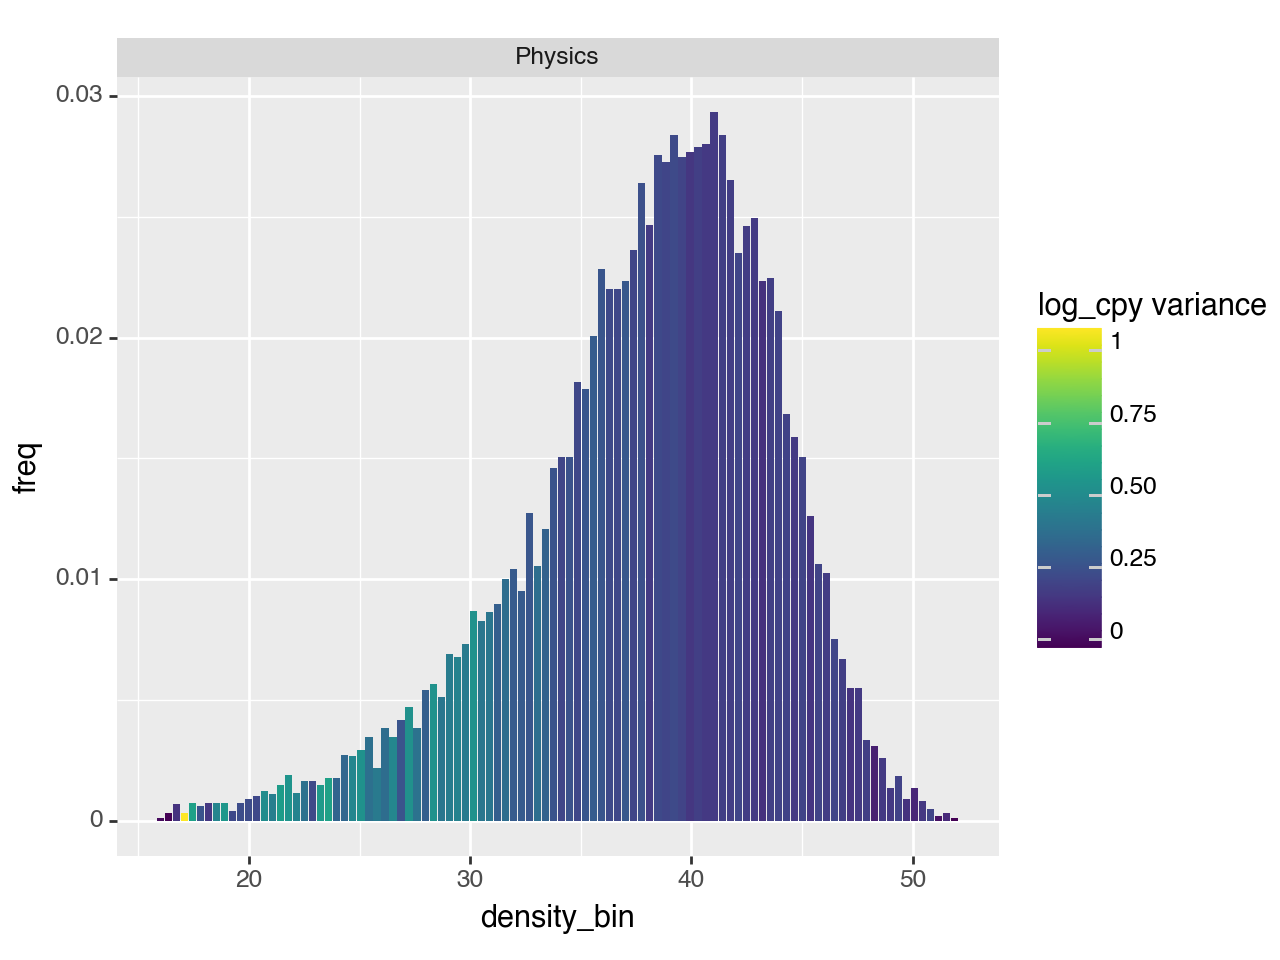

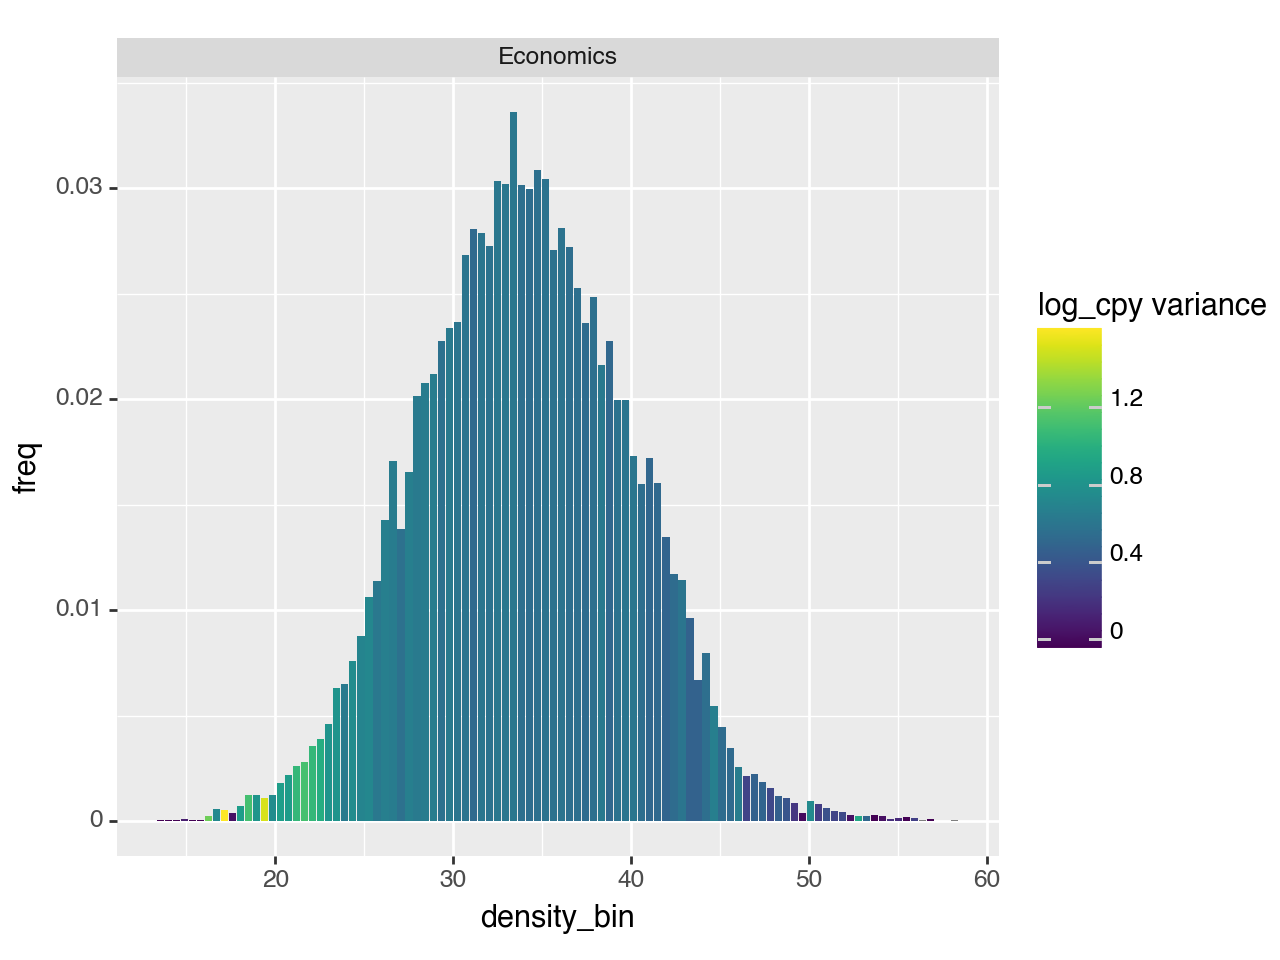

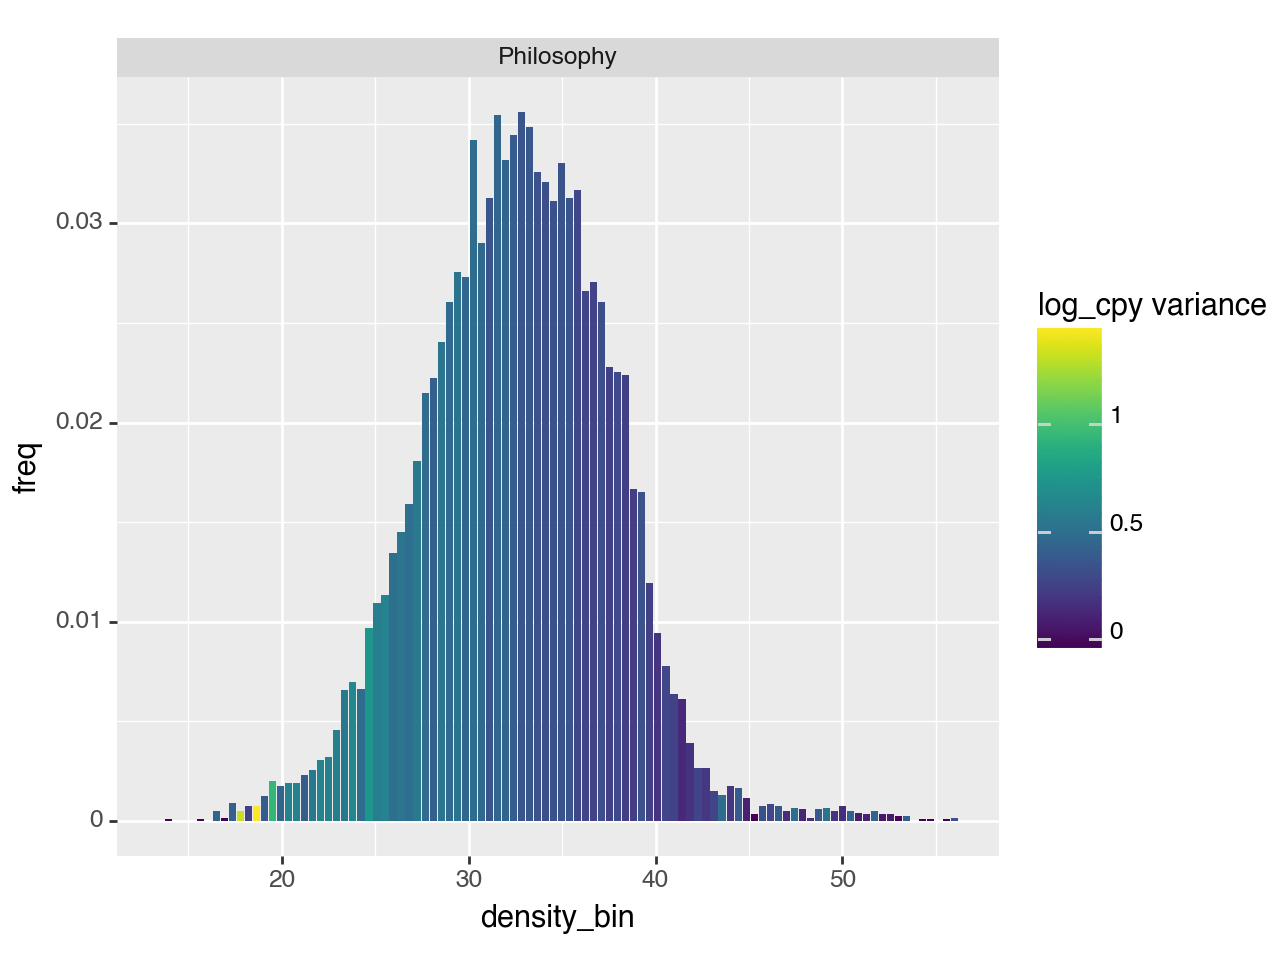

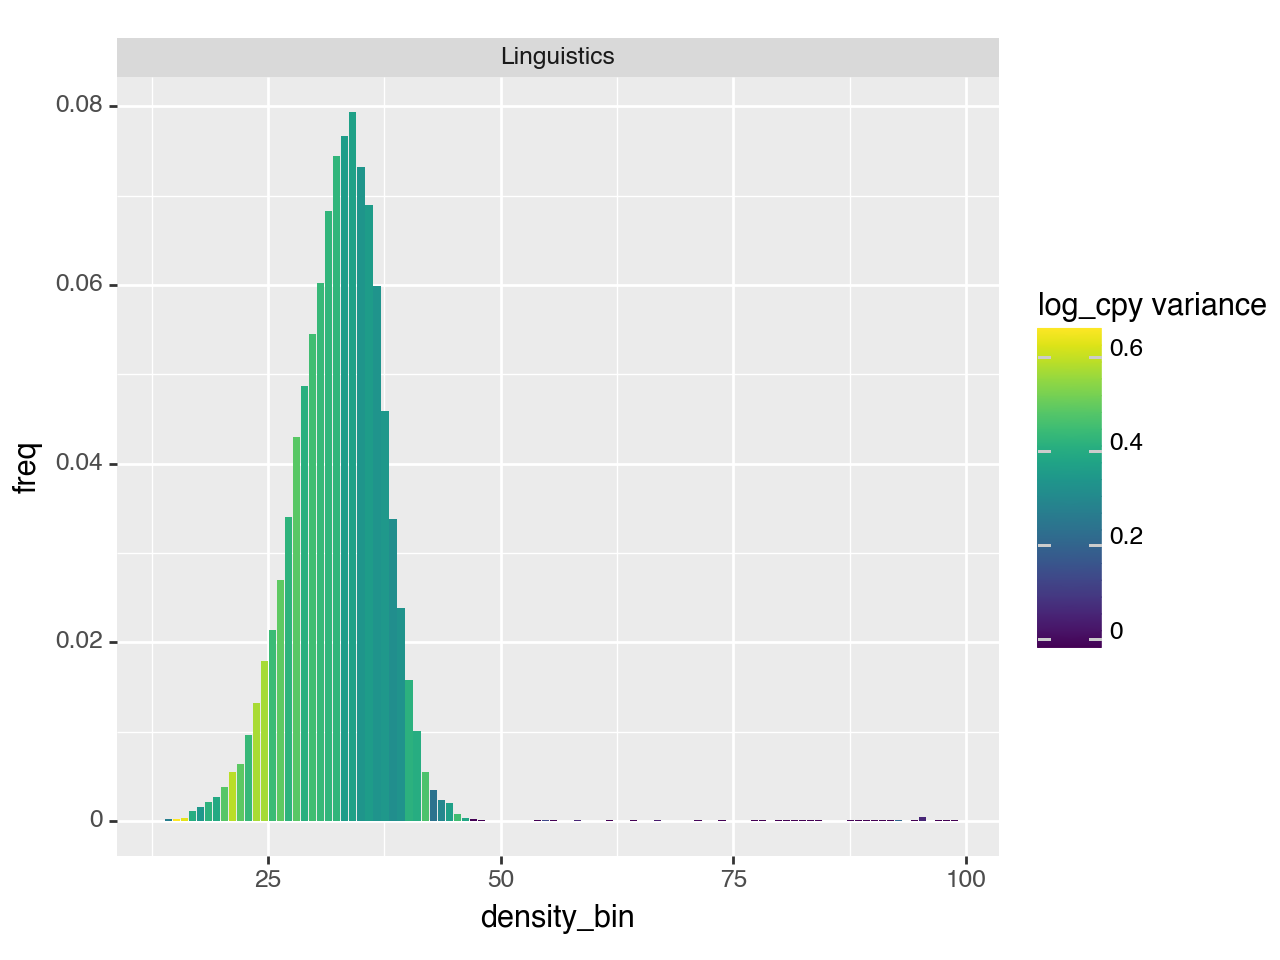

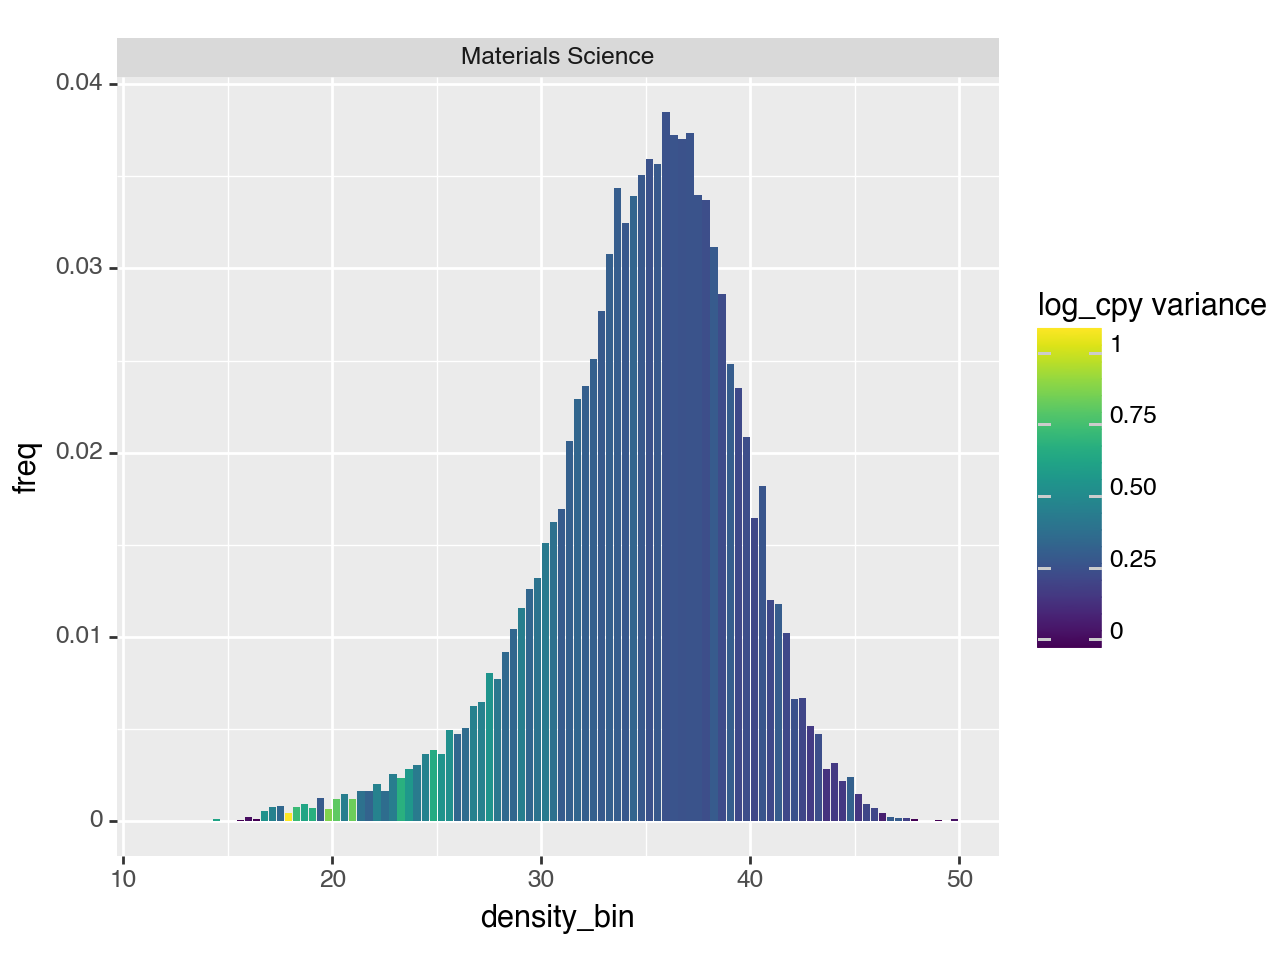

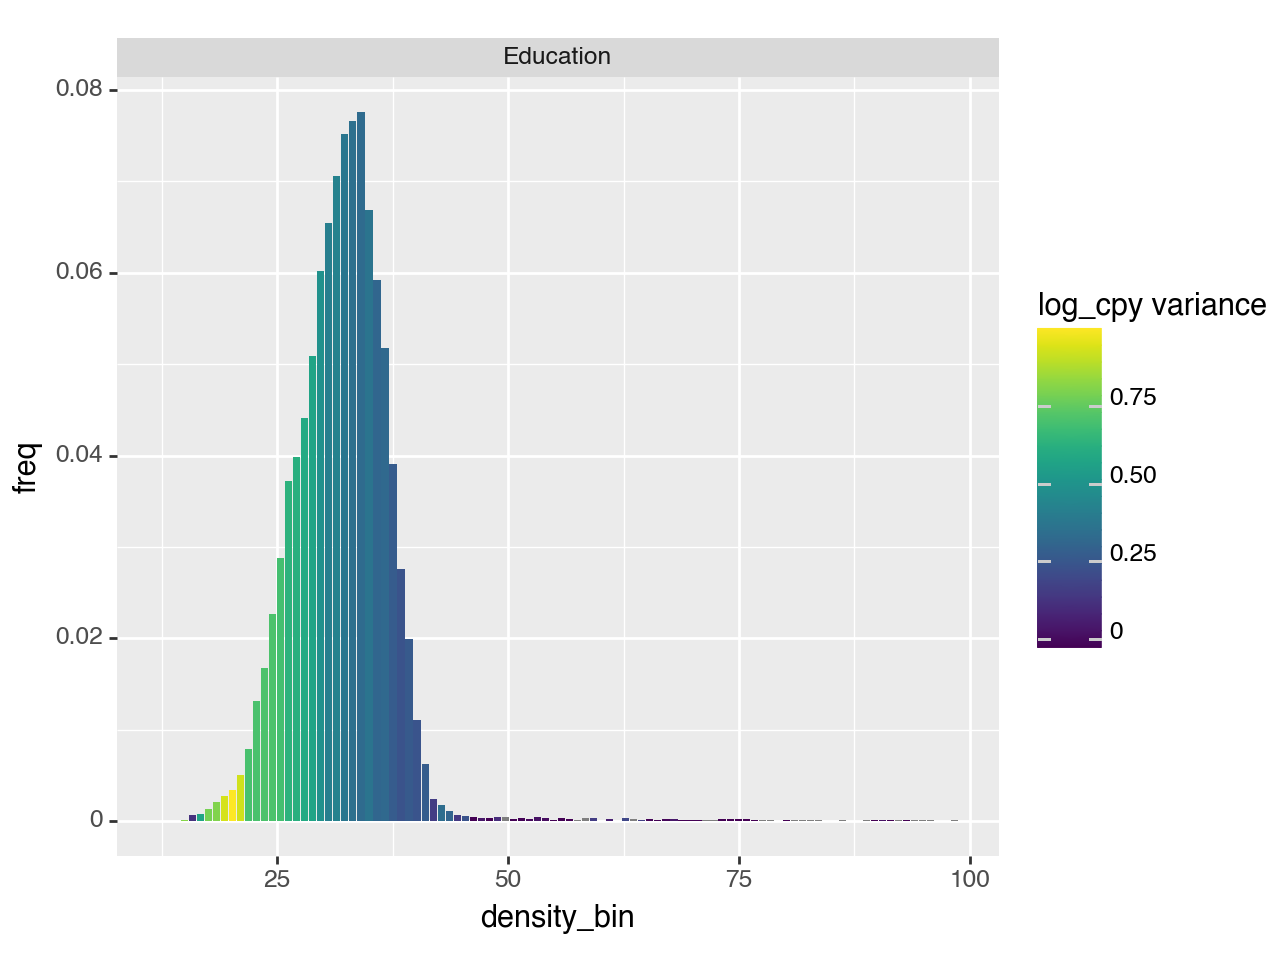

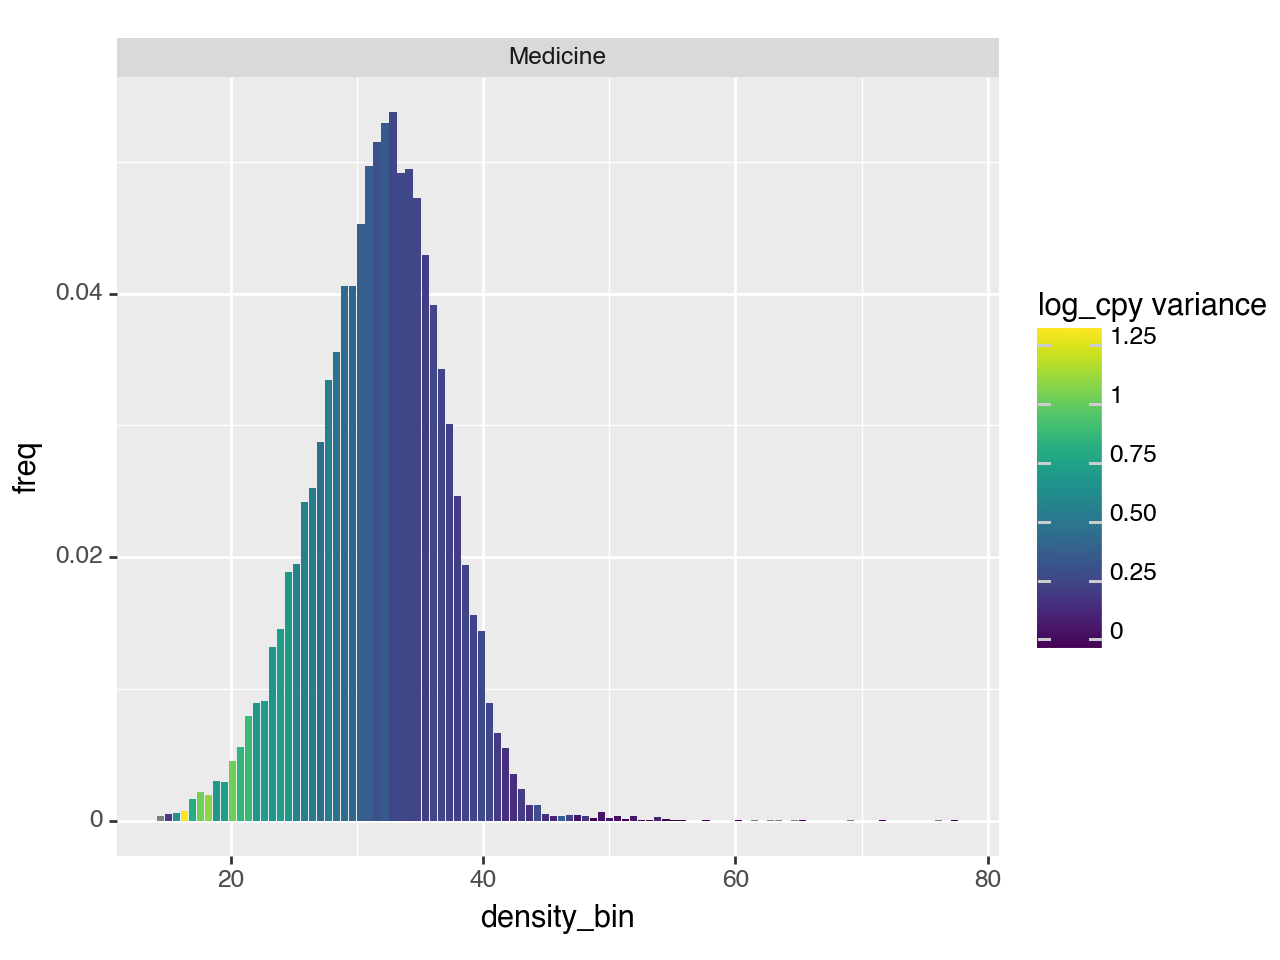

In [240]:
# First global, then facet by fields

# faceting isn't working so we're looping
for field in df_ent_all.field.unique():
    print(
        pn.ggplot(
            df_ent_all[df_ent_all["field"] == field], 
        )
        + pn.facet_wrap("field")
        + pn.geom_col(pn.aes(
            x="density_bin",
            # fill="citation entropy",
            fill="log_cpy variance",
            y="freq",
        ),size=10,
        )
        # + pn.labs(fill="citation entropy,\nH(CPY | density_bin)\n")
    )


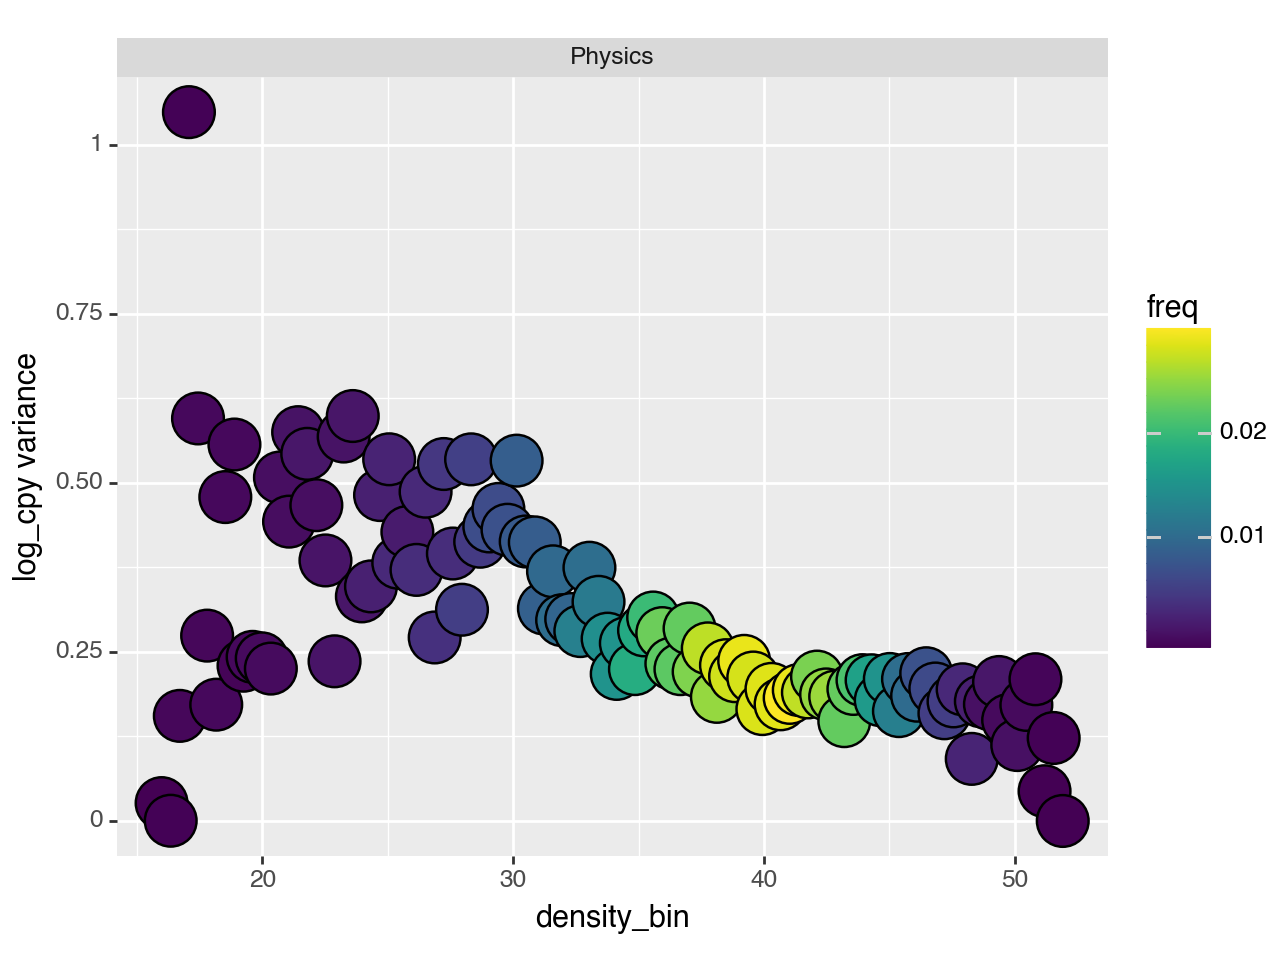


Regression:
LinregressResult(slope=-0.009036625357873486, intercept=0.5992291090397547, rvalue=-0.5970596892890496, pvalue=5.510766594248403e-11, stderr=0.0012264685653110392, intercept_stderr=0.04357063263178395)



/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


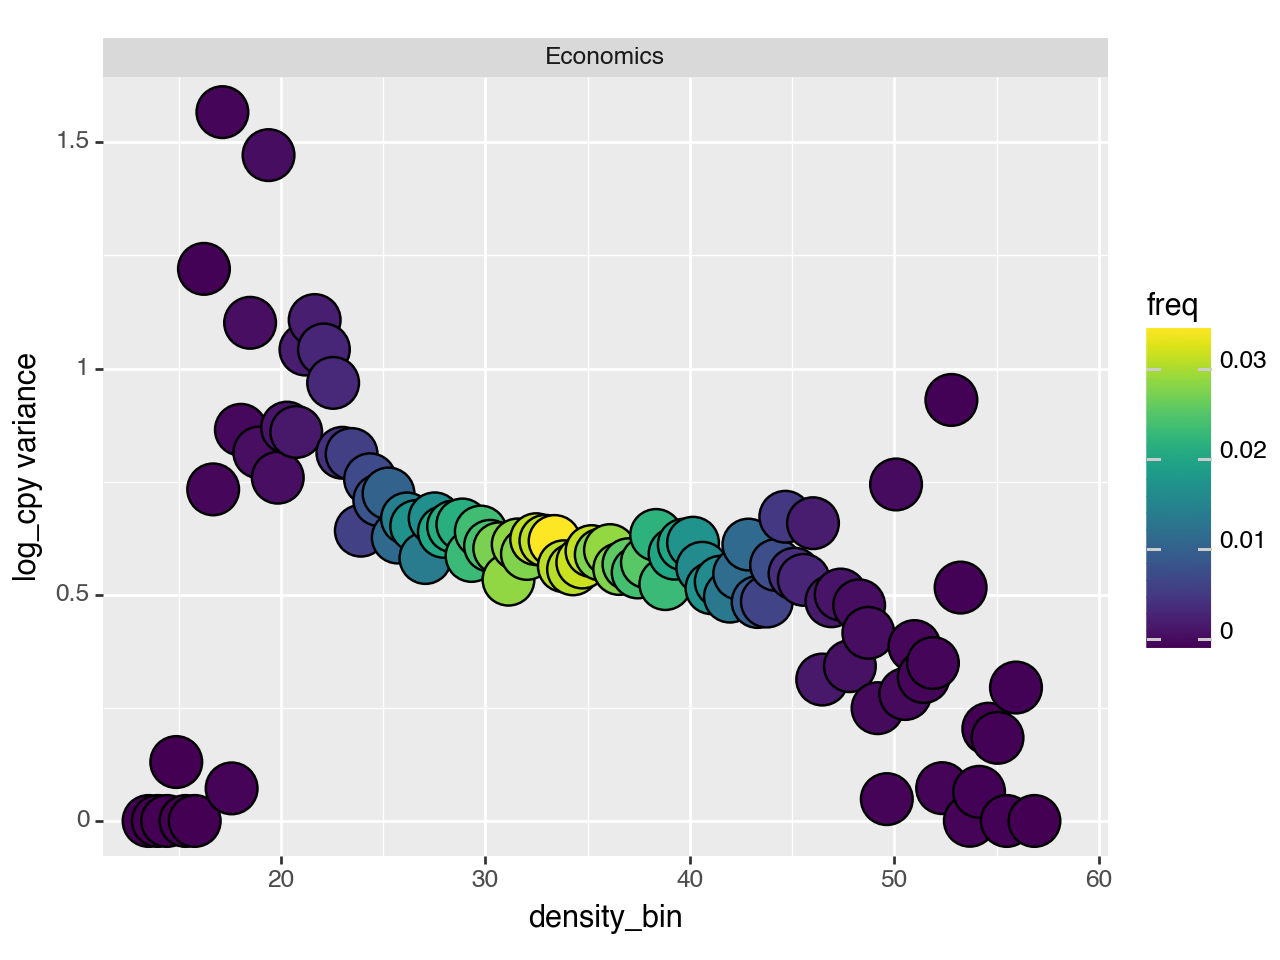


Regression:
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)



/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 7 rows containing missing values.


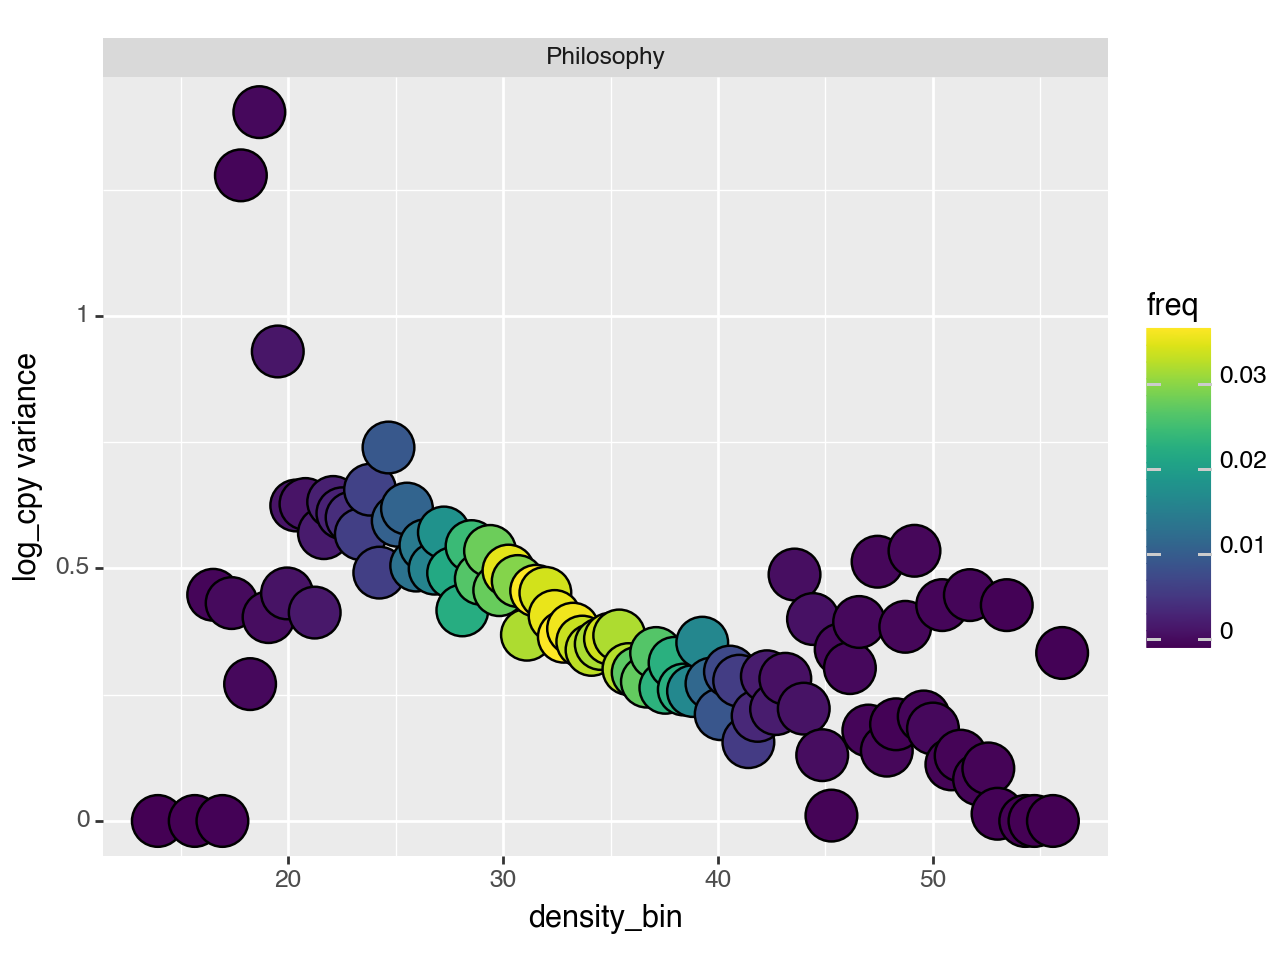


Regression:
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)



/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 31 rows containing missing values.


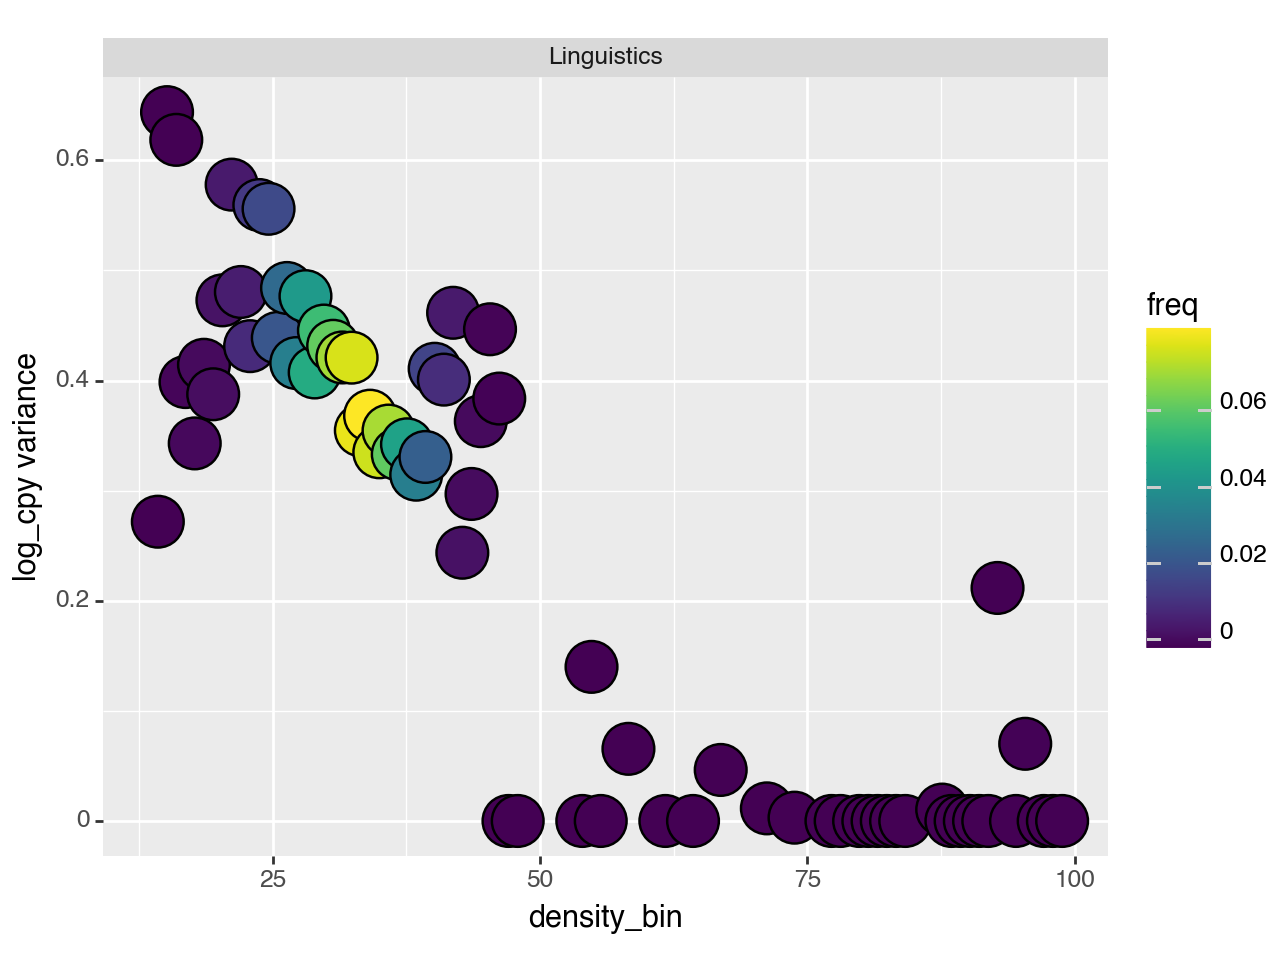


Regression:
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)



/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 12 rows containing missing values.


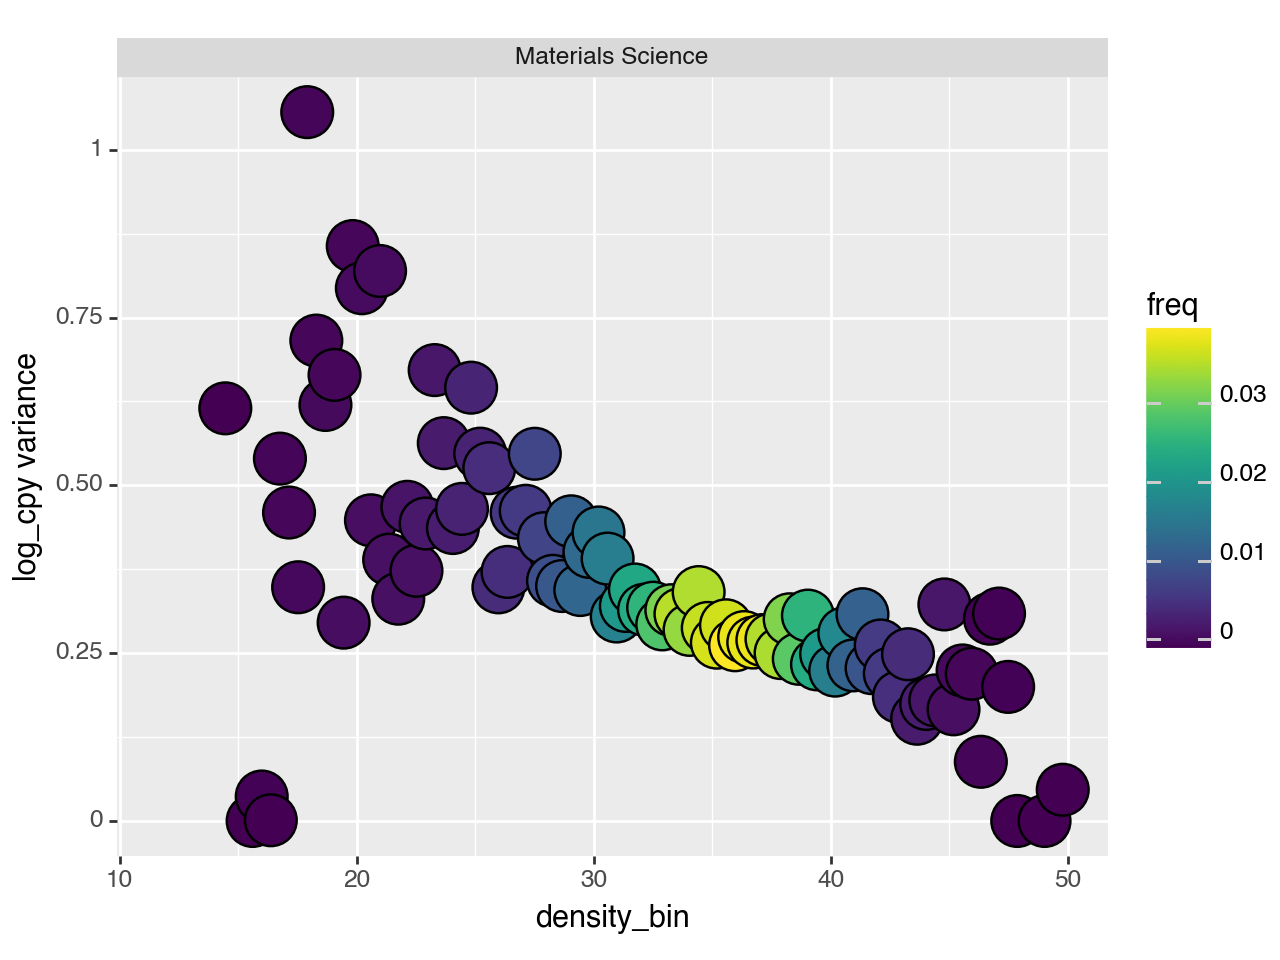


Regression:
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)



/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 31 rows containing missing values.


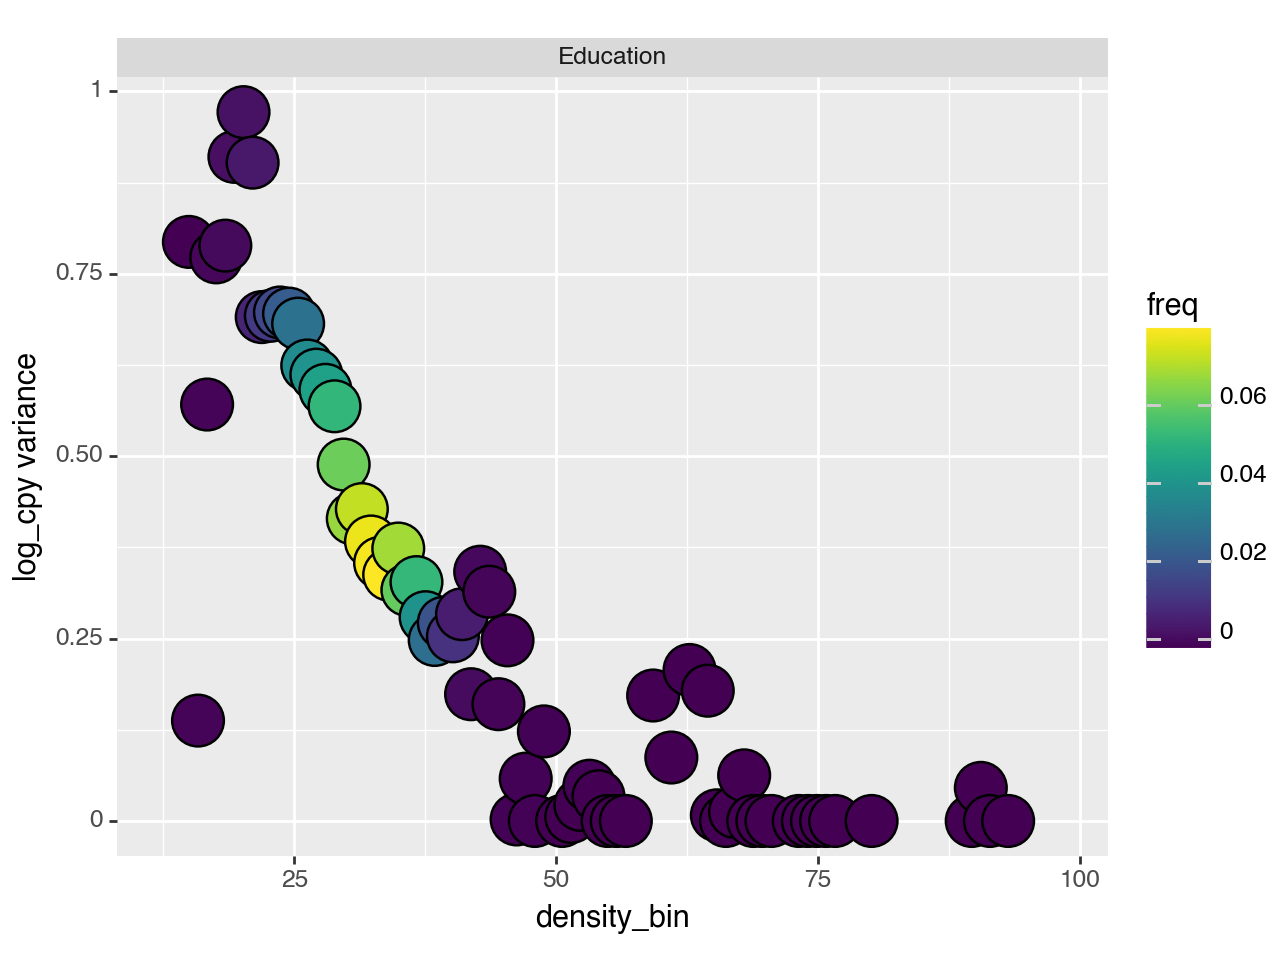


Regression:
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)



/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 30 rows containing missing values.


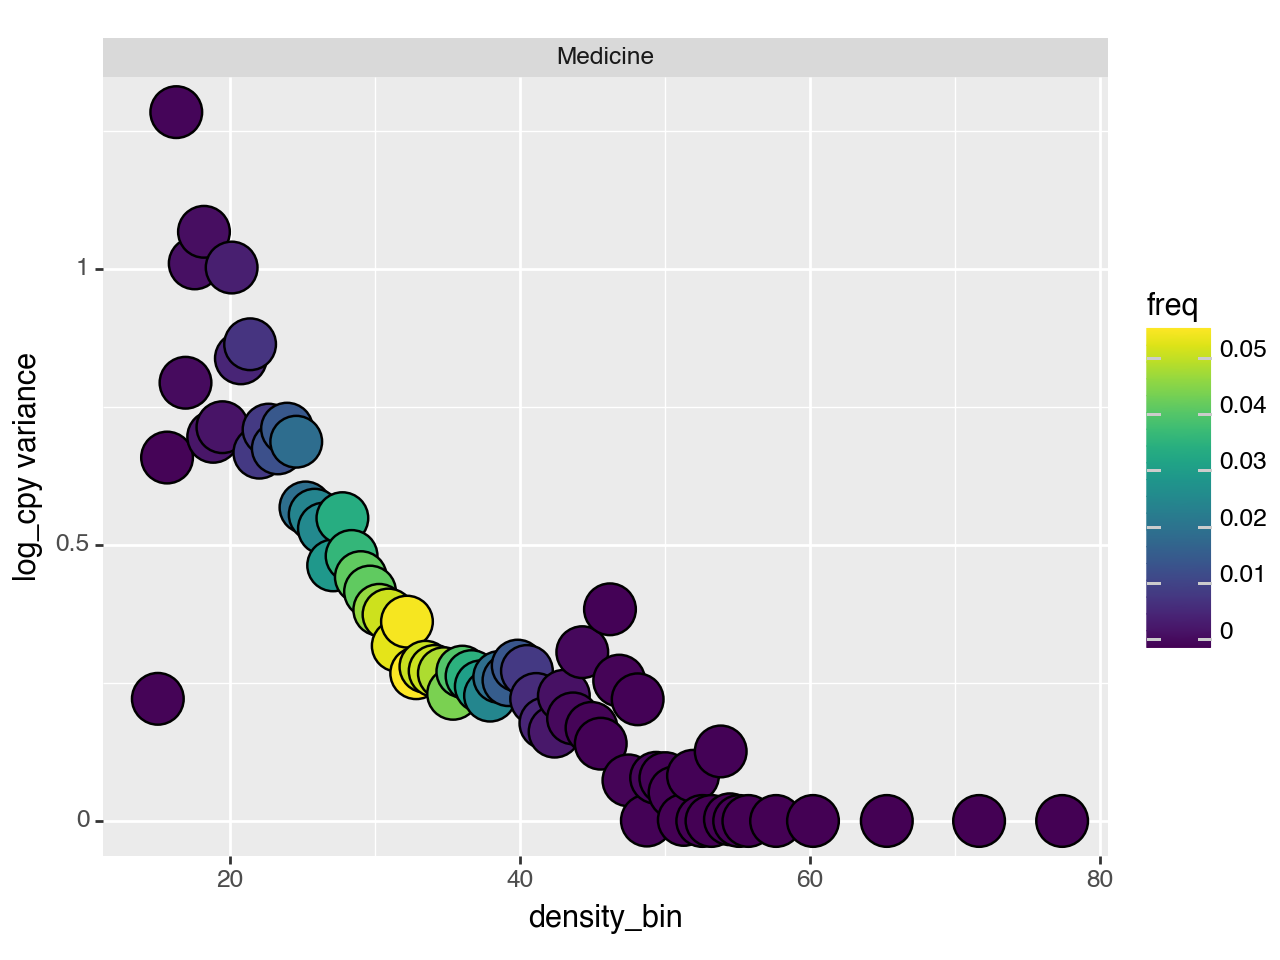


Regression:
LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)



In [242]:
from scipy.stats import linregress

for field in df_ent_all.field.unique():
    df_f = df_ent_all[df_ent_all["field"] == field]
    print(
        pn.ggplot(
            df_f, 
        )
        + pn.facet_wrap("field")
        + pn.geom_point(pn.aes(
            x="density_bin",
            y="log_cpy variance",
            fill="freq",
        ),size=10,
        )
    )
    print("Regression:")
    print(
        linregress(
            df_f["density_bin"],
            df_f["log_cpy variance"],
        )
    )
    print()



# I think something's still up. 
# Probably with how i'm computing entropy.

These will likely be significant.

